Raw data loaded successfully.
(41457, 22)
Null value counts:
 time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                19115
gap                12232
dmin               29334
rms                  881
net                    0
id                     0
updated                0
place                  0
type                   0
horizontalError    30649
depthError         16182
magError           29509
magNst              5916
status                 0
locationSource         0
magSource              0
dtype: int64
Null value counts after preprocessing:
 latitude         0
longitude        0
depth            0
mag              0
nst              0
gap              0
rms              0
depthError       0
magNst           0
year             0
month            0
hour             0
magType_m        0
magType_mb       0
magType_mb_lg    0
magType_ml       0
magType_ms       0
magType_mw  

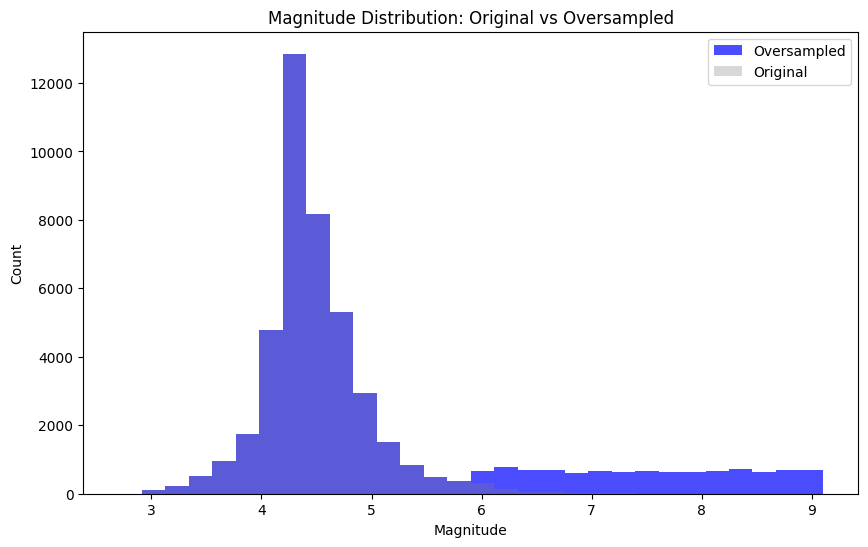

In [8]:
## Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import os
import matplotlib.pyplot as plt

## Load Raw Dataset
df_raw = pd.read_csv('japan_earthquakes_combined_filtered.csv')
print("Raw data loaded successfully.")
print(df_raw.shape)
print("Null value counts:\n", df_raw.isnull().sum())

## Preprocess Data and Handle Null Values
# Define target
target = 'mag'

# Drop irrelevant columns
cols_to_drop = ['id', 'updated', 'net', 'place', 'type', 'status', 'locationSource', 'magSource', 'dmin',
                'horizontalError', 'magError']
df_processed = df_raw.drop(columns=cols_to_drop)

# Convert time to numerical features
df_processed['time'] = pd.to_datetime(df_processed['time'])
df_processed['year'] = df_processed['time'].dt.year
df_processed['month'] = df_processed['time'].dt.month
df_processed['hour'] = df_processed['time'].dt.hour
df_processed = df_processed.drop(columns=['time'])

# Handle null values for numerical columns
numerical_cols = ['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'magNst']
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

# Handle categorical column (magType) - use mode to fill nulls, then one-hot encode
df_processed['magType'] = df_processed['magType'].fillna(df_processed['magType'].mode()[0])
df_processed = pd.get_dummies(df_processed, columns=['magType'], prefix='magType')

# Verify no null values remain
print("Null value counts after preprocessing:\n", df_processed.isnull().sum())

# Define features
features = [col for col in df_processed.columns if col != target]

# Store original magnitudes
original_mags = df_processed['mag'].copy()

# Discretize magnitude into binary class: < 6.0 vs. >= 6.0
df_processed['mag_class'] = (df_processed[target] >= 6.0).astype(int)

# Separate features and target class
X = df_processed[features]
y = df_processed['mag_class']

print("Class distribution before SMOTE:")
print(y.value_counts())

## Apply SMOTE
# Initialize SMOTE with a target minority class size
smote = SMOTE(
    sampling_strategy={1: 10000},  # Target at least 10,000 rows for mag >= 6.0
    random_state=42
)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print(f"Total rows after SMOTE: {len(X_resampled)}")

## Reconstruct DataFrame
# Create new DataFrame with resampled data
df_resampled = pd.DataFrame(X_resampled, columns=features)
df_resampled['mag_class'] = y_resampled

# Assign magnitudes: use original values for initial rows, random for new rows
max_mag = df_raw['mag'].max()
num_original = len(original_mags)
df_resampled['mag'] = np.concatenate([
    original_mags,  # First 41,457 rows
    np.random.uniform(6.0, max_mag, size=len(df_resampled) - num_original)  # Remaining 9,528 rows
])

# Drop the temporary class column
df_resampled = df_resampled.drop(columns=['mag_class'])

print("Resampled magnitude stats:\n", df_resampled['mag'].describe())

## Save Oversampled Dataset
os.makedirs('oversampled', exist_ok=True)
df_resampled.to_csv('oversampled/japan_earthquake_oversampled_raw.csv', index=False)
print("✅ Oversampled dataset saved successfully!")

## Optional: Verify Distribution
plt.figure(figsize=(10, 6))
plt.hist(df_resampled['mag'], bins=30, color='blue', alpha=0.7, label='Oversampled')
plt.hist(df_raw['mag'], bins=30, color='gray', alpha=0.3, label='Original')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Magnitude Distribution: Original vs Oversampled')
plt.legend()
plt.show()